# A look into kiva.org

Kiva is a non-profit organization that hosts a platform, kiva.org, to crowdfund loans to individuals and groups who otherwise may not have had access to capital. They provide a rich dataset of historical loans from 2006 to 2019.

In this notebook, we will first explore the dataset to glean insights and deeper understanding about the platform.

We will then consider the expected personal loss of making a single loan, and then withdrawing any repayment as soon as possible.

Finally, we will attempt to use machine learning models to predict which loans will get funded, and which will get fully repaid.

In [106]:
import pandas as pd
import matplotlib.colors as mplc
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy import stats
import numpy as np
import seaborn as sns

In [107]:
%matplotlib inline
# activate plot theme
import qeds
qeds.themes.mpl_style();

## Data Exploration


In [108]:
# Source: https://www.kiva.org/build/data-snapshots
loans_raw = pd.read_csv("datasets/loans_big.csv", parse_dates=["POSTED_TIME","PLANNED_EXPIRATION_TIME","DISBURSE_TIME","RAISED_TIME",])

The above dataset was provided by Kiva as a snapshot of their historical loans. Below is an example row:

In [109]:
pd.set_option('display.max_columns', 40)
loans_raw.dropna().head(1)

,LOAN_ID,LOAN_NAME,ORIGINAL_LANGUAGE,DESCRIPTION,DESCRIPTION_TRANSLATED,FUNDED_AMOUNT,LOAN_AMOUNT,STATUS,IMAGE_ID,VIDEO_ID,ACTIVITY_NAME,SECTOR_NAME,LOAN_USE,COUNTRY_CODE,COUNTRY_NAME,TOWN_NAME,CURRENCY_POLICY,CURRENCY_EXCHANGE_COVERAGE_RATE,CURRENCY,PARTNER_ID,POSTED_TIME,PLANNED_EXPIRATION_TIME,DISBURSE_TIME,RAISED_TIME,LENDER_TERM,NUM_LENDERS_TOTAL,NUM_JOURNAL_ENTRIES,NUM_BULK_ENTRIES,TAGS,BORROWER_NAMES,BORROWER_GENDERS,BORROWER_PICTURED,REPAYMENT_INTERVAL,DISTRIBUTION_MODEL
77657,807094,GUSTAVO,Spanish,Gustavo es soltero y vive con sus padres en La...,Gustavo is single and lives with his parents i...,500.0,500.0,funded,1745738.0,3002.0,Higher education costs,Education,to pay university tuition,BO,Bolivia,La Paz,shared,0.1,USD,48.0,2014-11-27 15:25:02+00:00,2015-01-25 02:20:02+00:00,2014-11-21 08:00:00+00:00,2014-12-21 15:17:44+00:00,20.0,17,2,1,"user_favorite, user_favorite, user_favorite",GUSTAVO,male,true,monthly,field_partner


In [110]:
min_date = loans_raw["POSTED_TIME"].min()
max_date = loans_raw["POSTED_TIME"].max()
print(f"The dataset contains {len(loans_raw)} loans in the date range {min_date} to {max_date}.")

The dataset contains 1682790 loans in the date range 2006-04-16 07:10:50+00:00 to 2019-02-25 04:12:27+00:00.


We will first explore the quality of the data and see if there will be any issues with missing data.

In [111]:
print(loans_raw.isnull().sum())

LOAN_ID                                  0
LOAN_NAME                            48555
ORIGINAL_LANGUAGE                    44209
DESCRIPTION                          44244
DESCRIPTION_TRANSLATED              453635
FUNDED_AMOUNT                            0
LOAN_AMOUNT                              0
STATUS                                   0
IMAGE_ID                             44209
VIDEO_ID                           1681943
ACTIVITY_NAME                            0
SECTOR_NAME                              0
LOAN_USE                             44232
COUNTRY_CODE                            29
COUNTRY_NAME                             0
TOWN_NAME                           163515
CURRENCY_POLICY                          0
CURRENCY_EXCHANGE_COVERAGE_RATE     337326
CURRENCY                                 0
PARTNER_ID                           18325
POSTED_TIME                              0
PLANNED_EXPIRATION_TIME             371834
DISBURSE_TIME                         3189
RAISED_TIME

There are some missing cells. However, the core data relating to the loans themselves are complete. Although cells relating to currencies are listed, manually investigating a sample revealed that all loan amounts are in USD.

We will proceed by asking some basic questions about the loans.


In [112]:
plt.rcParams['figure.figsize'] = (10, 5)

What are these loans going towards?

Text(0.5, 1.0, 'Loans by Sector')

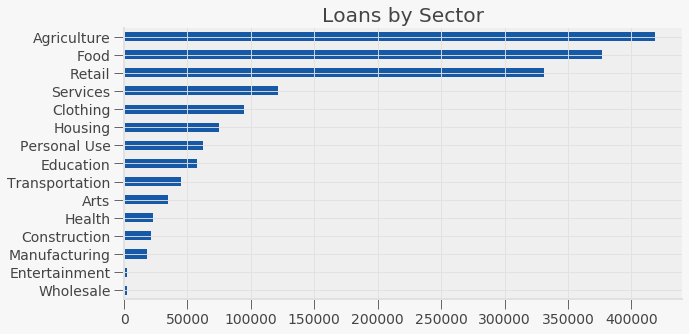

In [113]:
sectors = loans_raw["SECTOR_NAME"].value_counts().sort_values()
ax = sectors.plot.barh()
ax.set_title("Loans by Sector")

What about if we get slightly more granular?

Text(0.5, 1.0, 'Loans by Activity')

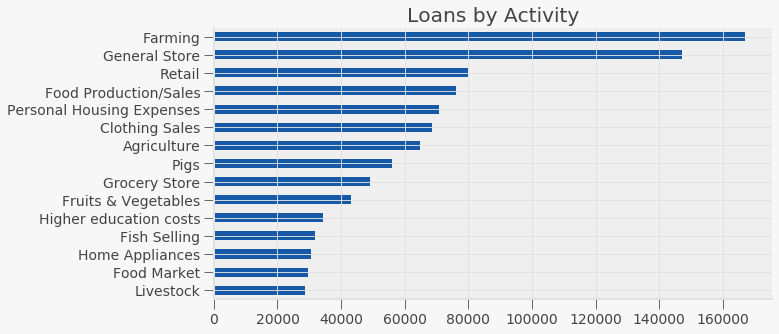

In [114]:
activities = loans_raw["ACTIVITY_NAME"].value_counts().nlargest(15).sort_values()
ax = activities.plot.barh()
ax.set_title("Loans by Activity")

<BarContainer object of 20 artists>

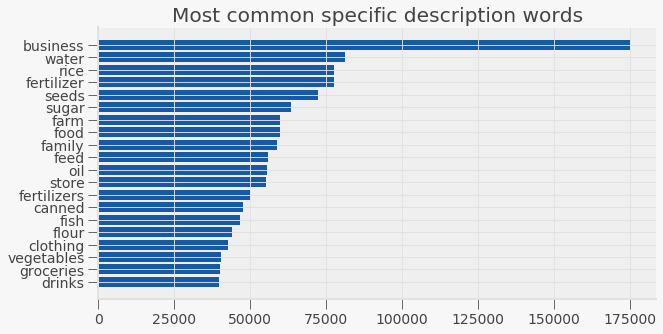

In [115]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text

additional_stopwords = ['buy', 'purchase', 'sell', 'pay', 'additional', 'items', 'materials', 'stock', 'like', 'goods',
                        'increase', 'new', 'improve', 'build', 'make', 'products', 'supplies']

stop_words = text.ENGLISH_STOP_WORDS.union(additional_stopwords)

vectorizer = CountVectorizer(stop_words=stop_words)
words = vectorizer.fit_transform(loans_raw["LOAN_USE"].dropna())
words_sum = words.sum(axis=0)

words_freq = [(word, words_sum[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

# The double sorting is because barh puts the first element at the bottom
top_20_words = sorted(words_freq[0:20], key=lambda x:x[1])

y = [word[0] for word in top_20_words]
width = [freq[1] for freq in top_20_words]

fig, ax = plt.subplots()
ax.set_title("Most common specific description words")
ax.barh(y, width=width)

As you can see, the most common reasons for loans are to help small businesses, such as farming and local retail.

What does the distribution of loan amounts look like?

Text(0.5, 0, 'Loan Amounts in USD')

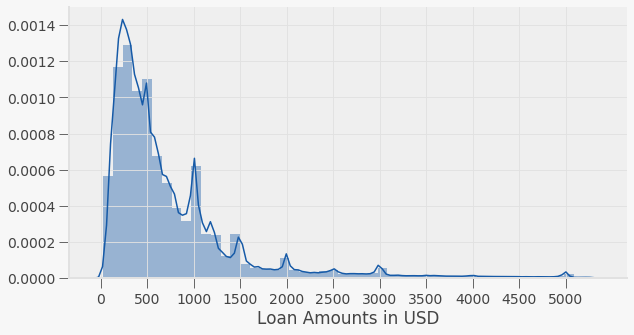

In [116]:
amounts = loans_raw['LOAN_AMOUNT']

# Remove outliers to be able to view amounts at a reasonable scale.
# These outliers are quite rare, but some have extremely large amounts, skewing the image.
def filter_outliers(data, crit=4):
    """Removes data points with a zscore magnitude greater than the critical value crit."""
    z = np.abs(stats.zscore(data))
    return data[(z < crit)]

filtered_amounts = filter_outliers(amounts)

ax = sns.distplot(filtered_amounts)
ax.set_xticks(np.arange(0, np.max(filtered_amounts) + 1, 500))
ax.set_xlabel("Loan Amounts in USD")

We can see that the most common loan amount is 250 USD, though multiples of 500 are generally more popular than surrounding amounts.

How many people tend to contribute to each loan?

8    78933
1    72962
9    72353
7    72134
5    69761
Name: NUM_LENDERS_TOTAL, dtype: int64


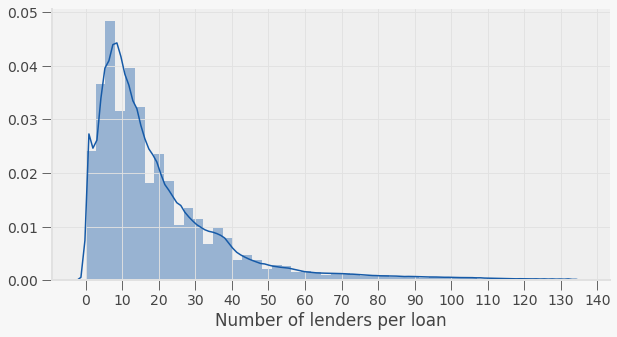

In [117]:
filtered_lenders = filter_outliers(loans_raw["NUM_LENDERS_TOTAL"])

ax = sns.distplot(filtered_lenders)
ax.set_xticks(np.arange(0, 141, 10))
ax.set_xlabel("Number of lenders per loan")

print(filtered_lenders.value_counts().head())

We see that the distribution is centered around 8 lenders, with a long right tail. However, we can also see that a significant number of loans were funded by only a single person.

The loans are not guaranteed to get fully funded. How many do not?

5.1% of loans do not get fully funded.
Of those, the mean amount funded is 56.4% of the ask.


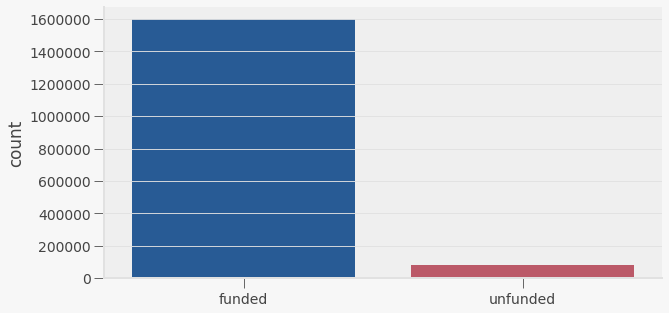

In [118]:
loan_diffs = amounts - loans_raw["FUNDED_AMOUNT"]
funding_status = ["funded" if diff == 0 else "unfunded" for diff in loan_diffs]

loan_diffs = loan_diffs[loan_diffs != 0]
percent_unfunded = ((loan_diffs.count() / amounts.count()) * 100).round(1)
print(f"{percent_unfunded}% of loans do not get fully funded.")

unfunded_asking_amounts = amounts[loan_diffs.index]
unfunded_ratios = loan_diffs / unfunded_asking_amounts
how_much_funded = (unfunded_ratios.mean() * 100).round(1)
print(f"Of those, the mean amount funded is {how_much_funded}% of the ask.")

sns.countplot(funding_status)

In [119]:
loans_raw["TIME_TO_FUND"] = loans_raw["RAISED_TIME"] - loans_raw["POSTED_TIME"]
loans_raw["DAYS_TO_FUND"] = [time.days for time in loans_raw["TIME_TO_FUND"]]
days_to_fund = filter_outliers(loans_raw["DAYS_TO_FUND"].dropna())

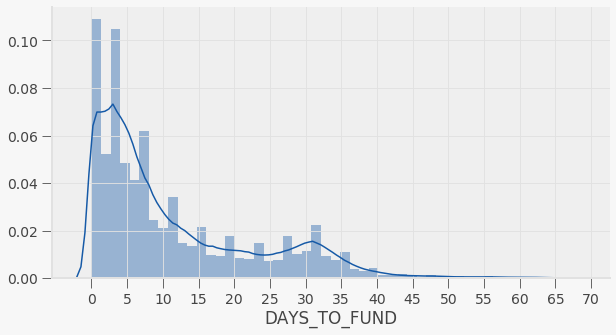

In [120]:
ax = sns.distplot(days_to_fund)
ax.set_xticks(np.arange(0, 71, 5))
plt.show()

Is there a relationship between the loan amount and the number of days it takes to fund the loan?

In [121]:
# Need to filter outliers but don't want to filter by different amounts
amounts_and_days = loans_raw[["LOAN_AMOUNT", "DAYS_TO_FUND"]]
amounts_and_days = amounts_and_days[(amounts_and_days["LOAN_AMOUNT"].isin(filtered_amounts))
                                    & (amounts_and_days["DAYS_TO_FUND"].isin(days_to_fund))]

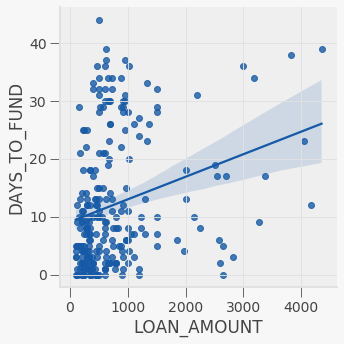

In [122]:
sample = amounts_and_days.sample(250)
sns.lmplot(x="LOAN_AMOUNT", y="DAYS_TO_FUND", data=sample, fit_reg=True)

Once the loans are distributed, there is no guarantee that they will be repaid. How many do not?

Unfortunately, there was no information to answer this question in the original dataset. We instead turn to a previously supplied dataset of 5000 randomly sampled loans with their repayment details, taken from https://stat.duke.edu/resources/datasets/kiva-loans

In [123]:
# Source: https://stat.duke.edu/resources/datasets/kiva-loans
repayments = pd.read_excel("datasets/loan_repayment_samples.xlsx")

# basket_amount was all n/a, video.youtube_id was not used
repayments = repayments.drop(["basket_amount", "video.youtube_id"], axis=1)

In [124]:
# This dataset has a row for each individual payment; aggregate these into a single row per loan
grouped_repayments = repayments.groupby("id", as_index=False).agg(lambda x: x.tolist())

2.0 % of loans in this sample have defaulted.


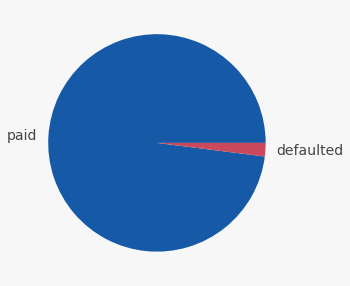

In [125]:
# Get the payment status of the loan
grouped_repayments["status"] = grouped_repayments["status"].agg(lambda x: "defaulted" if "defaulted" in x else "paid")

status_counts = grouped_repayments["status"].value_counts()
default_ratio = ((status_counts["defaulted"] / len(grouped_repayments)) * 100).round(1)
print(f"{default_ratio} % of loans in this sample have defaulted.")

fig, ax = plt.subplots()
ax.pie(x=status_counts, labels=["paid", "defaulted"])
plt.show()

What is the gender ratio of those receiving loans?

Loan recipients are 80.0% female and 20.0% male.


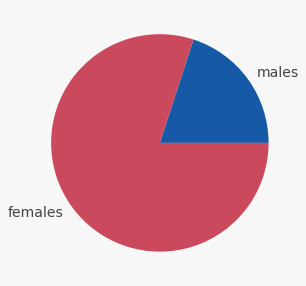

In [126]:
genders = loans_raw["BORROWER_GENDERS"].dropna()

# The gender entries include all recipients as a comma separated string, so a simple value_counts will not work.
females = 0
males = 0
for entry in genders:
    recipients = entry.split(", ")
    for gender in recipients:
        if gender == "female":
            females += 1
        else:
            males += 1
            
fig, ax = plt.subplots()
ax.pie(x=[males, females], labels=["males", "females"])

female_ratio = round((females / (females + males)) * 100, 1)
male_ratio = round(((males / (females + males)) * 100), 1)

print(f"Loan recipients are {female_ratio}% female and {male_ratio}% male.")

What about the lenders themselves? What can we determine about them?

In [127]:
lenders_raw = pd.read_csv("datasets/lenders.csv")
lenders_raw.dropna().head(1)

,PERMANENT_NAME,DISPLAY_NAME,MAIN_PIC_ID,CITY,STATE,COUNTRY_CODE,MEMBER_SINCE,PERSONAL_URL,OCCUPATION,LOAN_BECAUSE,OTHER_INFO,LOAN_PURCHASE_NUM,INVITED_BY,NUM_INVITED
11476,barketing,Erika Godwin,2899846.0,Ottawa,Ontario,CA,1528393535,www.barketing.co/,Business Owner,I loan because I want to help fellow female en...,I am co-founder of ProPet Software and owner o...,5,Bella,0


In [128]:
map_loans_to_lenders = pd.read_csv("datasets/loans_lenders.csv")
loans_raw = pd.merge(loans_raw, map_loans_to_lenders, on="LOAN_ID")

What are the nationalities of the lenders?

In [129]:
import squarify

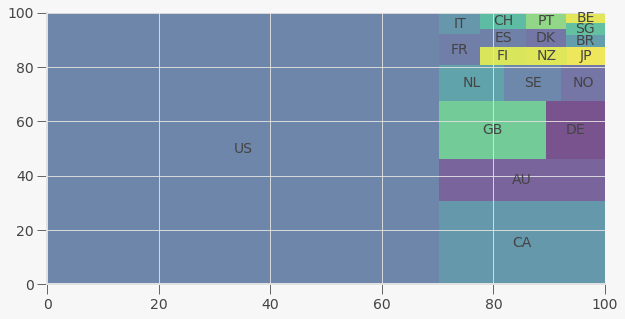

In [130]:
lenders_by_country = lenders_raw["COUNTRY_CODE"].value_counts()
ax = squarify.plot(
    sizes=lenders_by_country.values[0:20],
    label=lenders_by_country.index[0:20],
    alpha=.7
)

Evidently the majority of the users live in the US. Which states in particular?

In [132]:
state_mappings = pd.read_csv("datasets/states.csv")
state_pops = pd.read_csv("datasets/us_state_populations.csv")

In [133]:
import plotly.express as px

In [134]:
state_values = lenders_raw["STATE"].value_counts()
num_lenders_per_state = {}
for state in state_values.index[0:200]: # ignore the irrelevant state entries from other countries
    # Some entries have state as its full name, others its code; combine the two
    if state in state_mappings["State"].values:
        code = state_mappings[state_mappings["State"] == state]["Abbreviation"].iat[0]
        num_lenders_per_state[code] = num_lenders_per_state.get(code, 0) + state_values[state]
    elif state in state_mappings["Abbreviation"].values:
        num_lenders_per_state[state] = num_lenders_per_state.get(state, 0) + state_values[state]

us_lenders_by_state = pd.Series(num_lenders_per_state).sort_values(ascending=False)
print(us_lenders_by_state.head())

fig = px.choropleth(
    locations=us_lenders_by_state.index,
    color=us_lenders_by_state.values,
    locationmode="USA-states",
    title="Number of lenders per US state",
    scope="usa",
    color_continuous_scale=px.colors.sequential.Plasma
)
fig.show()

CA    57270
NY    20708
TX    16410
WA    15102
IL    12441
dtype: int64


The number of users in California more than doubles the next state. However, the above plots were with raw numbers, but what about adjusting for population?
Let's again look at countries first:

In [135]:
populations = pd.read_csv("datasets/world_pop.csv")

In [136]:
# Load a dictionary to convert iso2 to iso3 for other datasets and plotly
import urllib.request, json
with urllib.request.urlopen("http://country.io/iso3.json") as url:
    iso2_to_3_dict = json.loads(url.read().decode())

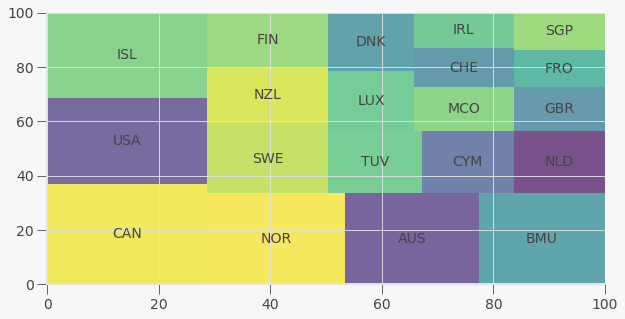

In [137]:
country_codes = []
per_capita_values = []
for country in lenders_by_country.index:
    code = iso2_to_3_dict.get(country)
    pop = populations[populations["Country Code"] == code]["2016"]
    
    if pop is None or len(pop) == 0:
        continue
        
    val = lenders_by_country[country] / pop.iat[0]
    country_codes.append(code)
    per_capita_values.append(val)
    

lenders_per_capita = pd.Series(per_capita_values, index=country_codes).sort_values(ascending=False)

ax = squarify.plot(
    sizes=lenders_per_capita.values[0:20],
    label=lenders_per_capita.index[0:20],
    alpha=0.7,
)

Per-capita, user nationality is much more evenly distributed, with Canada winning out. What about states?

In [138]:
us_per_capita_lenders = {}

for state in us_lenders_by_state.index:
    full_name = state_mappings[state_mappings["Abbreviation"] == state]["State"].iat[0]
    pop = state_pops[state_pops["NAME"] == full_name]["POPESTIMATE2019"].iat[0]
    us_per_capita_lenders[state] = us_lenders_by_state[state] / pop
    
us_per_capita_lenders = pd.Series(us_per_capita_lenders).sort_values(ascending=False)
print(us_per_capita_lenders.head())

fig = px.choropleth(
    locations=us_per_capita_lenders.index,
    color=us_per_capita_lenders.values,
    locationmode="USA-states",
    title="Number of per-capita lenders per state",
    scope="usa",
    color_continuous_scale=px.colors.sequential.Plasma
)
fig.show()

DC    0.004748
WA    0.001983
OR    0.001890
AK    0.001792
MA    0.001604
dtype: float64


After adjusting for population, California is no longer even in the top 5. Though difficult to see on the map, the number one spot goes to the District of Columbia. Another surprise is that Alaska comes in at number 4.

How many available loans are there at once? How has this changed over time as the organization has grown?

Text(0.5, 1.0, 'Number of available loans on the site')

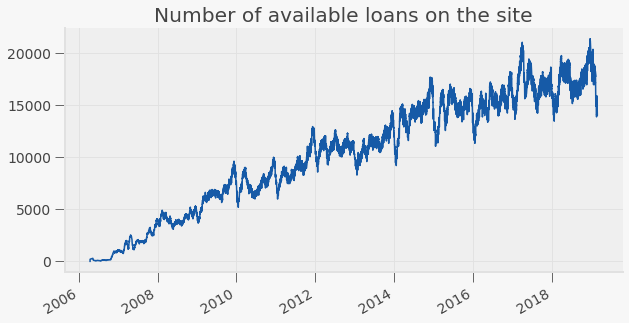

In [139]:
timeseries = loans_raw.set_index("POSTED_TIME").sort_index()
timeseries = timeseries.set_index(timeseries.index.to_pydatetime())
ax = timeseries["LOAN_ID"].rolling("30d").count().plot() # Loans are available for 30 days once posted
ax.set_title("Number of available loans on the site")

Text(0.5, 1.0, 'Amount Funded in 10s of millions')

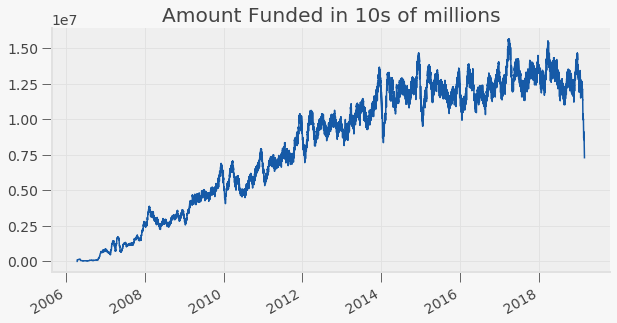

In [140]:
ax = timeseries["FUNDED_AMOUNT"].rolling("30d").sum().plot() # Loans are available for 30 days once posted
ax.set_title("Amount Funded in 10s of millions")

Which countries receive the most loans?

In [33]:
loans_raw["ISO3_CODES"] = [iso2_to_3_dict.get(code, np.nan) for code in loans_raw["COUNTRY_CODE"]]
countries = loans_raw["ISO3_CODES"].dropna()
loans_per_country = countries.value_counts()

fig = px.choropleth(
    locations=loans_per_country.index,
    color=loans_per_country.values,
    title="Number of loans per country",
    color_continuous_scale=px.colors.sequential.Plasma
)
fig.show()

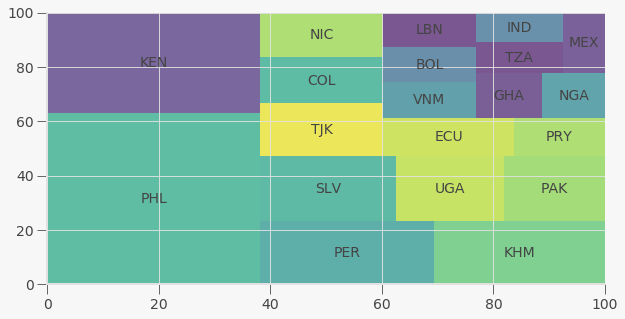

In [34]:
ax = squarify.plot(sizes=loans_per_country.values[0:20], label=loans_per_country.index[0:20], alpha=.7)

We can see that two countries have received significantly more loans than others: the Phillipines and Kenya, with the Phillipines receiving more than 300 thousand loans and Kenya receiving more than 170 thousand. After that, Peru, Cambodia, and El Salvador have each received close to 90 thousand loans.

What about the actual amounts received, rather than number of loans?

In [35]:
amounts_by_country = loans_raw.groupby("ISO3_CODES")["FUNDED_AMOUNT"].agg(sum)
sorted_amounts = amounts_by_country.sort_values(ascending=False)


In [36]:
fig = px.choropleth(
    locations=amounts_by_country.index,
    color=amounts_by_country,
    title="Dollars received in loans per country",
    color_continuous_scale=px.colors.sequential.Plasma
)
fig.show()

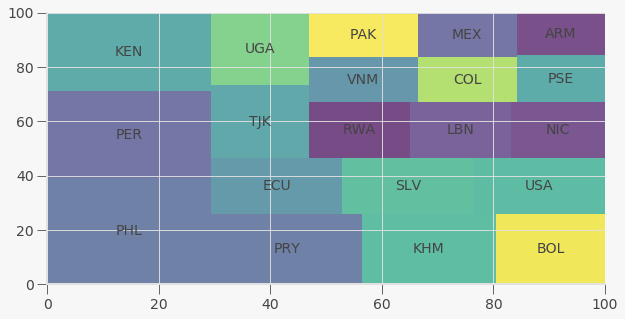

In [37]:
squarify.plot(sizes=sorted_amounts.values[0:20], label=sorted_amounts.index[0:20], alpha=.7)

When sorting by amount received rather than number of loans, the United States appear in the top 10. Why might that be?

Text(0.5, 1.0, 'US loans by Activity')

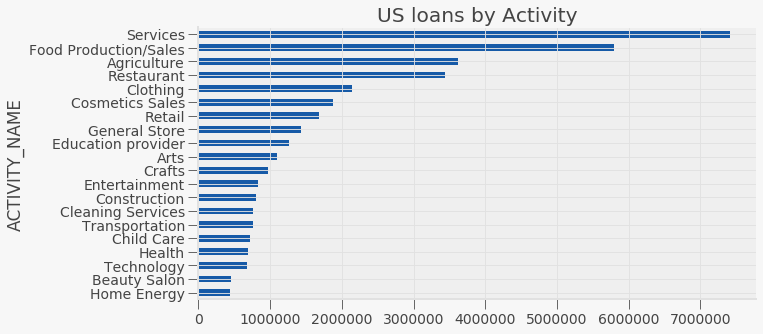

In [38]:
us_loans = loans_raw[loans_raw["COUNTRY_NAME"] == "United States"]
us_activities_by_amount = us_loans.groupby("ACTIVITY_NAME")["FUNDED_AMOUNT"].agg(sum).sort_values(ascending=False)
ax = us_activities_by_amount[0:20].sort_values().plot.barh()
ax.set_title("US loans by Activity")

Although I originally hypothesized that perhaps the loans were for personal health care, Kiva focuses its within-US efforts on supporting entrepreneurs, leading to the activity breakdown above.

Compared to the rest of the countries that receive significant amounts of money through Kiva, the US seems like an outlier. How does its distribution of lenders compare to other countries?

Text(0.5, 1.0, 'Lender countries for US loans')

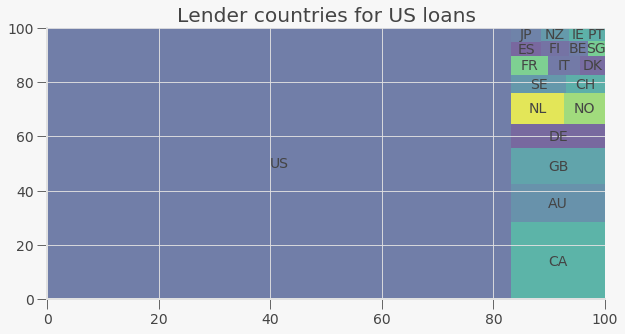

In [96]:
us_lenders = us_loans["LENDERS"]

made_us_loan = set()
def get_lender_names(lenders_csv):
    lender_usernames = lenders_csv.split(", ")
    for name in lender_usernames:
        made_us_loan.add(name)
    
us_lenders.apply(get_lender_names)

lenders_by_username = lenders_raw.set_index("PERMANENT_NAME")

filtered_us_lenders = lenders_raw[lenders_raw["PERMANENT_NAME"].isin(made_us_loan)]
filtered_us_lenders = filtered_us_lenders[filtered_us_lenders["COUNTRY_CODE"].notna()]

country_codes = lenders_raw["COUNTRY_CODE"]
lender_countries = {country: 0 for country in country_codes.unique()}
def count_lender_countries(lender):
    country_code = lender["COUNTRY_CODE"]
    lender_countries[country_code] += 1

    
filtered_us_lenders.apply(count_lender_countries, axis=1)

codes_df = pd.DataFrame(lender_countries.values(), index=lender_countries.keys(), columns=["LENDER_COUNT"])
us_lender_countries = codes_df.nlargest(20, columns="LENDER_COUNT")
ax = squarify.plot(sizes=us_lender_countries.values[0:20], label=us_lender_countries.index[0:20], alpha=.7)
ax.set_title("Lender countries for US loans")

As one might expect, the percentage of US loans that are funded by US citizens is larger than the baseline for all loans, going from roughly 70% to over 80%.

Looking into the United States led to the question: what are the largest average loan amounts per country?

Text(0.5, 1.0, 'Average loan amounts by country')

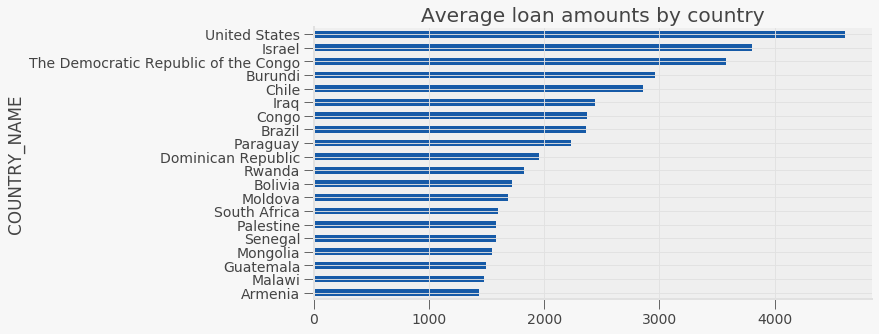

In [40]:
def get_large_sample_size_mean(country_loans):
    """Returns the mean of a country's loans if the sample size is at least 500, otherwise 0."""
    return 0 if len(country_loans) < 500 else np.mean(country_loans)

avg_amt_by_country = loans_raw.groupby("COUNTRY_NAME")["FUNDED_AMOUNT"].agg(get_large_sample_size_mean).sort_values(ascending=False)
ax = avg_amt_by_country[0:20].sort_values().plot.barh()
ax.set_title("Average loan amounts by country")

## Costs of Lending

Using Duke's sample dataset, we previously estimated that the loan default rate was roughly 2%. We will proceed using this estimate to calculate the expected personal loss in present value when making a single loan.

We will make the following simplifying assumptions:
1. Only loans with monthly repayment schemes (which make up 87% of the dataset) are considered
1. The loans are made uniformly and randomly, without any selection from the lender
2. Currency exchange rates are held constant, removing the risk of gain/loss due to dollar fluctuations
3. Defaulted loans do not return any invested money whatsoever
4. Returns are immediately withdrawable

In order to compute the expected loss, we must figure out the expected repayment intervals.

In [41]:
monthly_loans = loans_raw[loans_raw["REPAYMENT_INTERVAL"] == "monthly"]
num_repayments = monthly_loans["LENDER_TERM"].mean().round()
print(num_repayments)
print(default_ratio)

13.0
2.0


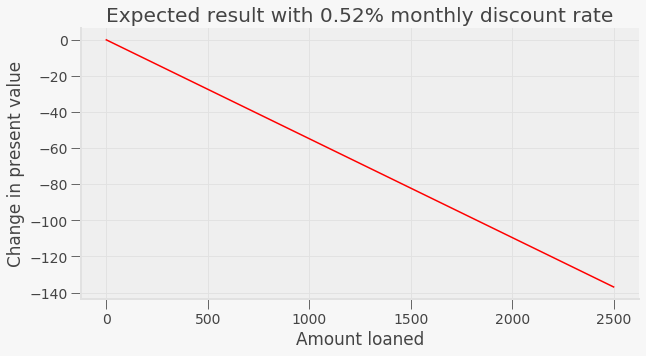

In [141]:
def NPV(pay_per_period, discount_rate, n_periods):
    """Return the Net Present Value of an asset."""
    result = 0
    for t in range(1, int(n_periods) + 1):
        result += pay_per_period / (1 + discount_rate)**t
        
    return result


def expected_loss(initial_amount, discount_rate=0.035, num_repayments=13):
    pay_per_period = initial_amount / num_repayments
    
    # default ratio was computed as an integer, get the probability that we get our money back
    chance_to_repay = (100 - default_ratio) / 100
    
    expected_discounted_value = chance_to_repay * NPV(pay_per_period, discount_rate, num_repayments)
    
    # discounted value - current value is how much we're losing
    return expected_discounted_value - initial_amount


x = np.linspace(0, 2500, 50) # amounts of money we could loan

discount = 0.0052 # current long-term average S&P 500 monthly return
# (according to https://ycharts.com/indicators/sp_500_monthly_total_return)
y = expected_loss(x, discount, num_repayments)

fig, ax = plt.subplots(1)
ax.set_xlabel("Amount loaned")
ax.set_ylabel("Change in present value")
ax.set_title("Expected result with 0.52% monthly discount rate")

ax.plot(x, y, 'r')

Assuming that one would've otherwise put the money into an index fund, if one is willing to accept the variance of these loans, they can provide \\$1000 worth of capital while only losing roughly \$55 in present value.

## Predicting funding

We now turn to the task of attempting to use the dataset to predict whether a loan will be fully funded or not. Because the dataset has multiple different data types, missing values, and superfluous features, it requires quite a bit of preprocessing before we can pass it to machine learning models.

First, we will split the features into 3 sets and ensure that each set can be trained on:
1. numerical; these are the easiest to work with, we just need to interpolate missing values.
2. categorical; these are text features that we expect to have a limited range of values. We apply one-of-K encoding to turn these features into dummy variables.
3. descriptive; these are text features that are full English sentences. We apply bag-of-words to vectorize and transform these features into more convenient forms for learning.

Second, we will try learning on these sets of features individually to try to see if any are more predictive than others. We will construct an ensemble of classification models to first benchmark each model's individual performance, and then the performance of the models together.

Finally, we will combine all that we have done previously into one large benchmark. If we get any promising preliminary results for a particular model, we may spend more time optimizing that final model by tuning scikit-learn parameters and model hyperparameters.

In [43]:
# For the sake of the exercise, ignore features that: 
# 1) are not populated upon the loan first being available
# 2) are irrelevant ids unique to the loan

# Note that disbursed dates are typically available when first viewing the loan,
# either as pre-dispursal from the partner or as the expected date

number_features = [
    'LOAN_AMOUNT',
    'DISBURSE_TIME',
    'LENDER_TERM',
    'CURRENCY_EXCHANGE_COVERAGE_RATE',
    'POSTED_TIME'
]

categorical_features = [
    'ACTIVITY_NAME',
    'SECTOR_NAME',
    'COUNTRY_CODE',
    'COUNTRY_NAME',
    'TOWN_NAME',
    'CURRENCY_POLICY',
    'CURRENCY',
    'TAGS',
    'BORROWER_GENDERS',
    'BORROWER_PICTURED',
    'PARTNER_ID',
]

description_features = [
    'LOAN_USE',
    'DESCRIPTION',
    'DESCRIPTION_TRANSLATED'
]

In [44]:
import logging
import sys
from time import time

from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier


In [45]:
# Source: forked from https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html#sphx-glr-auto-examples-text-plot-document-classification-20newsgroups-py
# License: BSD 3 clause

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

def benchmark(clf, name, X_train, X_test, y_train, y_test):
    print('=' * 80)
    print(name)
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))
        print()
            
    print("confusion matrix:")
    print(metrics.confusion_matrix(y_test, pred))
            
    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time
    

def rank_classifiers(X_train, X_test, y_train, y_test, n_iters=100, njobs=-1):
    results = []
    classifiers = []
    
    # Baseline
    mode = y_train.value_counts().index[0]
    score = len(y_test[y_test.values == mode]) / len(y_test)
    results.append(
        ("Predict Mode",
        score,
        0,
        0)
    )
    
    print('=' * 80)
    print("Predict the Mode")
    print('_' * 80)
    print("Score:", score)
    print()
    
    for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="auto"), "Ridge Classifier"),
        (Perceptron(max_iter=n_iters, n_jobs=-1), "Perceptron"),
        (MLPClassifier(max_iter=n_iters, early_stopping=True), "Neural Network"),
        (PassiveAggressiveClassifier(max_iter=n_iters * 10, n_jobs=njobs), "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=5, n_jobs=njobs), "kNN"),
        (RandomForestClassifier(max_depth=n_iters, n_jobs=njobs), "Random forest")):
            
        results.append(benchmark(clf, name, X_train, X_test, y_train, y_test))
        classifiers.append((name, clf))
        

    for penalty in ["l2", "l1"]:
        name = f"Liblinear with {penalty.upper()} penalty"
        clf = LinearSVC(penalty=penalty, dual=False, tol=1e-3, max_iter = n_iters * 10)
        results.append(benchmark(clf, name, X_train, X_test, y_train, y_test))
        classifiers.append((name, clf))     

        name = f"Ordinary SGD with {penalty.upper()} penalty"
        clf = SGDClassifier(alpha=.0001, max_iter=n_iters, penalty=penalty, n_jobs=njobs)
        results.append(benchmark(clf, name, X_train, X_test, y_train, y_test))
        classifiers.append((name, clf)) 

    name = "SGD with Elastic Net penalty"
    clf = SGDClassifier(alpha=.0001, max_iter=n_iters, penalty="elasticnet", n_jobs=njobs)
    results.append(benchmark(clf, name, X_train, X_test, y_train, y_test))
    classifiers.append((name, clf))

    name = "LinearSVC with L1-based feature selection"
    # The smaller C, the stronger the regularization.
    # The more regularization, the more sparsity.
    clf = Pipeline([
        ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False, tol=1e-3))),
        ('classification', LinearSVC(penalty="l2"))
    ])
    results.append(benchmark(clf, name, X_train, X_test, y_train, y_test))
    classifiers.append((name, clf))
    
    # Ensemble methods were causing intermittent mmap file errors on windows
    try:
        name = "Voting classifier with all previous estimators"
        voting_classifier = VotingClassifier(estimators=classifiers)
        results.append(benchmark(voting_classifier, name, X_train, X_test, y_train, y_test))

        name = "Stacking classifier with all previous estimators"
        stacking_classifier = StackingClassifier(estimators=classifiers)
        results.append(benchmark(stacking_classifier, name, X_train, X_test, y_train, y_test))
    
    except:
        pass
    
    
    return results


def plot_rankings(results):
    indices = np.arange(len(results))

    results = [[x[i] for x in results] for i in range(4)]

    clf_names, score, training_time, test_time = results
    training_time = np.array(training_time) / np.max(training_time)
    test_time = np.array(test_time) / np.max(test_time)

    plt.figure(figsize=(14, 10))
    plt.title("Score")
    plt.barh(indices, score, .2, label="score", color='navy')
    plt.barh(indices + .3, training_time, .2, label="training time", color='c')
    plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
    plt.yticks(())
    plt.legend(loc='best')
    plt.subplots_adjust(left=.25)
    plt.subplots_adjust(top=.95)
    plt.subplots_adjust(bottom=.05)

    for i, c in zip(indices, clf_names):
        plt.text(-.3, i, c)

    plt.show()
    

For the sake of time, we only run the models on a very small subset of the dataset. Previous trial runs that used the full dataset have never shown significant differences in performance.

Predict the Mode
________________________________________________________________________________
Score: 0.9466296599704109

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None,
                solver='auto', tol=0.01)
train time: 12.113s
test time:  0.019s
accuracy:   0.946
dimensionality: 185898
density: 0.130184

confusion matrix:
[[   85     3  3719     0]
 [    3     1   201     0]
 [  218     8 77195     1]
 [    0     0   298    55]]

Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=100, n_iter_no_change=5, n_jobs=-1,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=

C:\Users\Wes\anaconda3\envs\untitled\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:573: UserWarning:

Training interrupted by user.



train time: 3927.056s
test time:  0.280s
accuracy:   0.935
confusion matrix:
[[  578     0  3229     0]
 [   10     0   195     0]
 [ 1678     3 75672    69]
 [    0     0   143   210]]

Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=100, n_iter_no_change=5,
                            n_jobs=-1, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False)
train time: 0.822s
test time:  0.024s
accuracy:   0.928
dimensionality: 185898
density: 0.061616

confusion matrix:
[[  714     8  3085     0]
 [   16     1   188     0]
 [ 2280    19 75114     9]
 [    0     0   262    91]]

kNN
________________________________________________________________

C:\Users\Wes\anaconda3\envs\untitled\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



train time: 23.342s
test time:  0.014s
accuracy:   0.945
dimensionality: 185898
density: 0.011362

confusion matrix:
[[  111     3  3693     0]
 [    3     2   200     0]
 [  394    16 76992    20]
 [    0     0   190   163]]

Ordinary SGD with L1 penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=100, n_iter_no_change=5, n_jobs=-1, penalty='l1',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
train time: 0.514s
test time:  0.026s
accuracy:   0.947
dimensionality: 185898
density: 0.000440

confusion matrix:
[[    0     1  3806     0]
 [    0     0   205     0]
 [    2     0 77419     1]
 [    0     0   341    12]]

SGD w

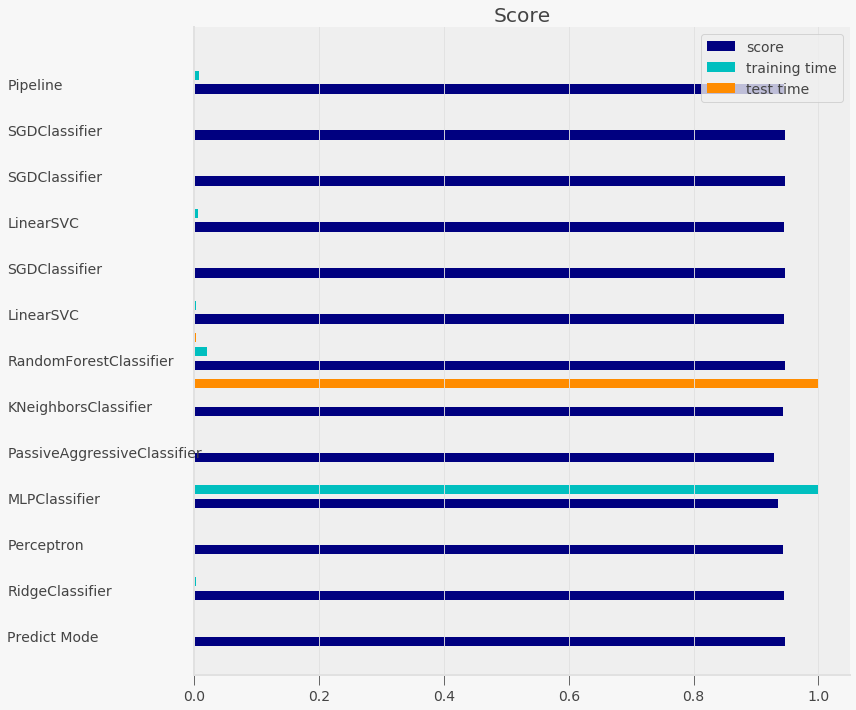

In [46]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

X_cat = loans_raw[categorical_features]
X_cat = X_cat.fillna("")

y = loans_raw["STATUS"]

categories = [X_cat[column].unique() for column in X_cat]

cat_pipe = make_pipeline(
    SimpleImputer(missing_values=None,
                  strategy='constant',
                  fill_value='missing'),
    OneHotEncoder(categories=categories)
)

X_train, X_test, y_train, y_test = train_test_split(X_cat, y, train_size=0.01, test_size=0.01)

cat_pipe.fit(X_train)
X_train = cat_pipe.transform(X_train)
X_test = cat_pipe.transform(X_test)

cat_results = rank_classifiers(X_train, X_test, y_train, y_test, 100)
plot_rankings(cat_results)

Predict the Mode
________________________________________________________________________________
Score: 0.9467538818926519

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None,
                solver='auto', tol=0.01)
train time: 0.113s
test time:  0.003s
accuracy:   0.948
dimensionality: 5
density: 1.000000

confusion matrix:


C:\Users\Wes\anaconda3\envs\untitled\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning:

Ill-conditioned matrix (rcond=4.67162e-39): result may not be accurate.



[[   21     0   749     0]
 [    0     0    33     0]
 [    7     0 15480     0]
 [    7     0    61     0]]

Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=-1,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)
train time: 0.125s
test time:  0.002s
accuracy:   0.948
dimensionality: 5
density: 1.000000

confusion matrix:
[[   21     0   749     0]
 [    0     0    33     0]
 [    0     0 15487     0]
 [    7     0    61     0]]

Neural Network
________________________________________________________________________________
Training: 
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes

C:\Users\Wes\anaconda3\envs\untitled\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



train time: 10.384s
test time:  0.002s
accuracy:   0.946
dimensionality: 5
density: 0.600000

confusion matrix:
[[    0     0   770     0]
 [    0     0    33     0]
 [    9     0 15478     0]
 [    0     0    68     0]]

Ordinary SGD with L1 penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l1',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


C:\Users\Wes\anaconda3\envs\untitled\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.



train time: 1.234s
test time:  0.002s
accuracy:   0.948
dimensionality: 5
density: 0.900000

confusion matrix:
[[   21     0   749     0]
 [    0     0    33     0]
 [    2     0 15485     0]
 [    7     0    61     0]]

SGD with Elastic Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1,
              penalty='elasticnet', power_t=0.5, random_state=None,
              shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
              warm_start=False)
train time: 0.534s
test time:  0.001s
accuracy:   0.948
dimensionality: 5
density: 1.000000

confusion matrix:
[[   21     0   749     0]
 [    0     0    33     0]
 [    0     0 15487     0]
 [    7     0    61   

C:\Users\Wes\anaconda3\envs\untitled\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\Wes\anaconda3\envs\untitled\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



train time: 5.300s
test time:  0.001s
accuracy:   0.604
confusion matrix:
[[ 275   51  177  267]
 [   8    3   12   10]
 [1413 1914 9589 2571]
 [   6    4   39   19]]



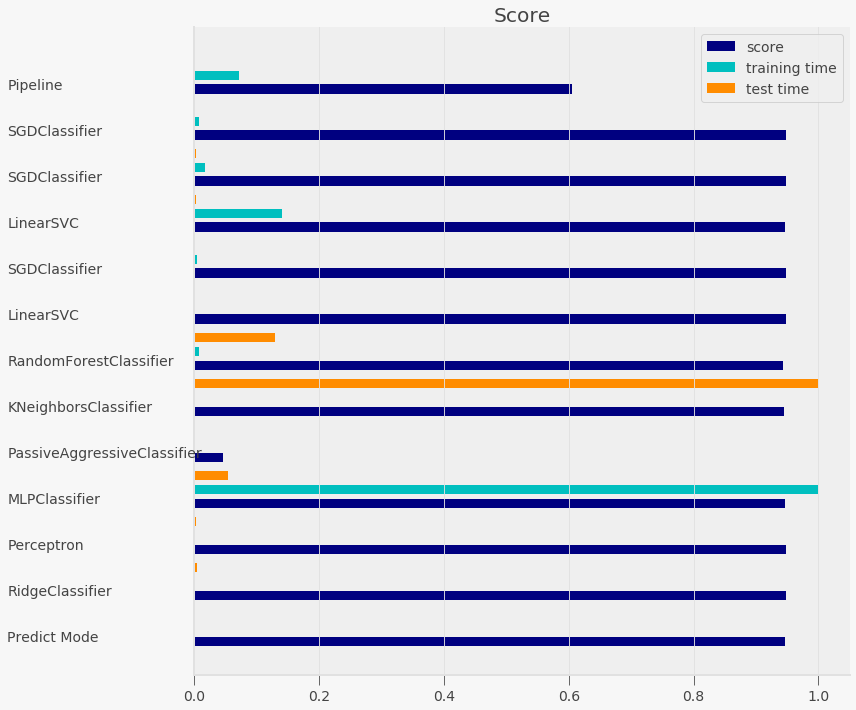

In [47]:
loans_raw['DISBURSE_TIME'] = pd.to_numeric(loans_raw['DISBURSE_TIME'])
loans_raw['POSTED_TIME'] = pd.to_numeric(loans_raw['POSTED_TIME'])

X_num = loans_raw[number_features]
y = loans_raw["STATUS"]

X_train, X_test, y_train, y_test = train_test_split(X_num, y, train_size=0.01, test_size=0.01)

num_pipe = make_pipeline(SimpleImputer(strategy='mean'))

X_train = num_pipe.fit_transform(X_train)
X_test = num_pipe.transform(X_test)

number_results = rank_classifiers(X_train, X_test, y_train, y_test, 1000)
plot_rankings(number_results)

Predict the Mode
________________________________________________________________________________
Score: 0.948771243428292

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None,
                solver='auto', tol=0.01)
train time: 2.286s
test time:  0.051s
accuracy:   0.948
dimensionality: 87434
density: 1.000000

confusion matrix:
[[    9     0   739     0]
 [    0     0    29     0]
 [   29     0 15491     0]
 [    0     0    61     0]]

Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=-1,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.

train time: 0.667s
test time:  0.067s
accuracy:   0.949
dimensionality: 87434
density: 0.026663

confusion matrix:
[[    0     0   748     0]
 [    0     0    29     0]
 [    1     0 15519     0]
 [    0     0    61     0]]

LinearSVC with L1-based feature selection
________________________________________________________________________________
Training: 
Pipeline(memory=None,
         steps=[('feature_selection',
                 SelectFromModel(estimator=LinearSVC(C=1.0, class_weight=None,
                                                     dual=False,
                                                     fit_intercept=True,
                                                     intercept_scaling=1,
                                                     loss='squared_hinge',
                                                     max_iter=1000,
                                                     multi_class='ovr',
                                                     penalty='l1',
        

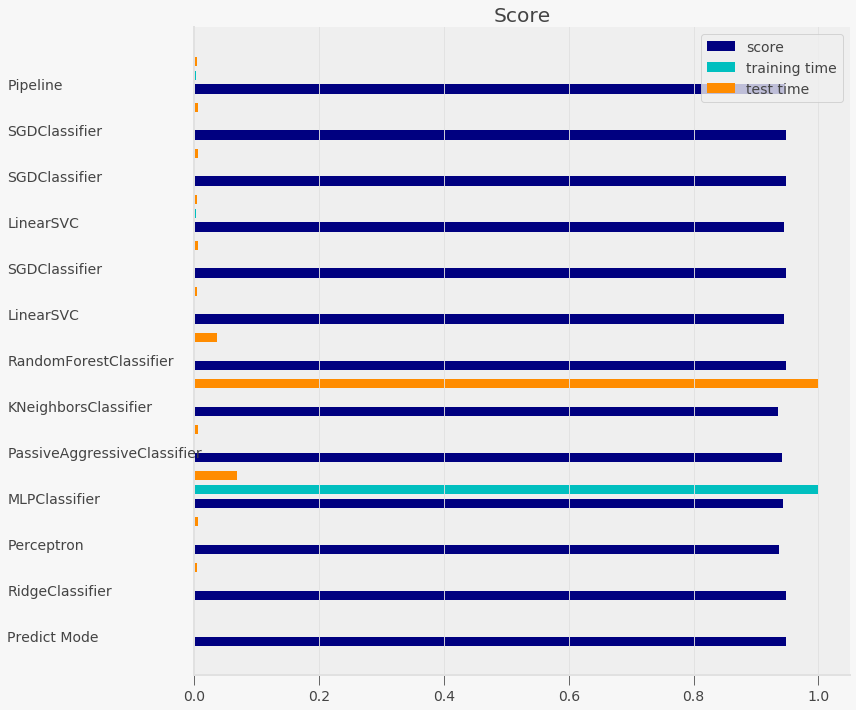

In [62]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import coo_matrix, hstack

description_pipe = make_pipeline(
    TfidfVectorizer(),
    TfidfTransformer()
)

X_desc = loans_raw[description_features].fillna("")
y = loans_raw["STATUS"]

X_train, X_test, y_train, y_test = train_test_split(X_desc, y, train_size=0.01, test_size=0.01)

# was too annoying to setup the initial matrix to do it in a loop
def get_description_features(X_train, X_test, description_pipe):
    sparse_X_train = description_pipe.fit_transform(X_train["LOAN_USE"])
    sparse_X_test = description_pipe.transform(X_test["LOAN_USE"])

    sparse_X_train = hstack( [sparse_X_train, description_pipe.fit_transform(X_train["DESCRIPTION"])] )
    sparse_X_test = hstack( [sparse_X_test, description_pipe.transform(X_test["DESCRIPTION"])] )

    sparse_X_train = hstack( [sparse_X_train, description_pipe.fit_transform(X_train["DESCRIPTION_TRANSLATED"])] )
    sparse_X_test = hstack( [sparse_X_test, description_pipe.transform(X_test["DESCRIPTION_TRANSLATED"])] )
    
    return (sparse_X_train, sparse_X_test)

sparse_X_train, sparse_X_test = get_description_features(X_train, X_test, description_pipe)

description_results = rank_classifiers(sparse_X_train, sparse_X_test, y_train, y_test, 1000)
plot_rankings(description_results)

In [63]:
from sklearn.compose import make_column_transformer

feature_transformer = make_column_transformer(
    (cat_pipe, categorical_features),
    (num_pipe, number_features),
    remainder="drop"
)

X = pd.concat([X_num, X_cat, X_desc], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.005, test_size=0.01)

sparse_X_train, sparse_X_test = get_description_features(X_train, X_test, description_pipe)

X_train = feature_transformer.fit_transform(X_train)
X_test = feature_transformer.transform(X_test)

sparse_X_train = hstack([sparse_X_train, X_train])
sparse_X_test = hstack([sparse_X_test, X_test])

Predict the Mode
________________________________________________________________________________
Score: 0.9454701063699719

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None,
                solver='auto', tol=0.01)
train time: 12029.864s
test time:  0.062s
accuracy:   0.048
dimensionality: 273486
density: 1.000000

confusion matrix:
[[  783     0     0     0]
 [   32     0     0     0]
 [15466     0     0     0]
 [   77     0     0     0]]

Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=100, n_iter_no_change=5, n_jobs=-1,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fracti

C:\Users\Wes\anaconda3\envs\untitled\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.



train time: 14823.147s
test time:  1.302s
accuracy:   0.945
confusion matrix:
[[    0     0   783     0]
 [    0     0    32     0]
 [    0     0 15466     0]
 [    0     0    77     0]]

Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=100, n_iter_no_change=5,
                            n_jobs=-1, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False)
train time: 0.388s
test time:  0.087s
accuracy:   0.946
dimensionality: 273486
density: 0.180614

confusion matrix:
[[    0     0   768    15]
 [    0     0    32     0]
 [    0     0 15466     0]
 [    0     0    73     4]]

kNN
_______________________________________________________________

C:\Users\Wes\anaconda3\envs\untitled\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning:

Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.



train time: 1.573s
test time:  0.082s
accuracy:   0.946
dimensionality: 273486
density: 0.243842

confusion matrix:
[[    0     0   768    15]
 [    0     0    32     0]
 [    0     0 15466     0]
 [    0     0    73     4]]

Liblinear with L1 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l1', random_state=None, tol=0.001,
          verbose=0)


C:\Users\Wes\anaconda3\envs\untitled\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



train time: 155.035s
test time:  0.058s
accuracy:   0.941
dimensionality: 273486
density: 0.004079

confusion matrix:
[[   52     2   729     0]
 [    0     0    32     0]
 [  129     4 15323    10]
 [    0     0    51    26]]

Ordinary SGD with L1 penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=100, n_iter_no_change=5, n_jobs=-1, penalty='l1',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
train time: 3.406s
test time:  0.078s
accuracy:   0.944
dimensionality: 273486
density: 0.001841

confusion matrix:
[[    0     0   768    15]
 [    0     0    32     0]
 [    0    27 15439     0]
 [    0     0    73     4]]

SGD 

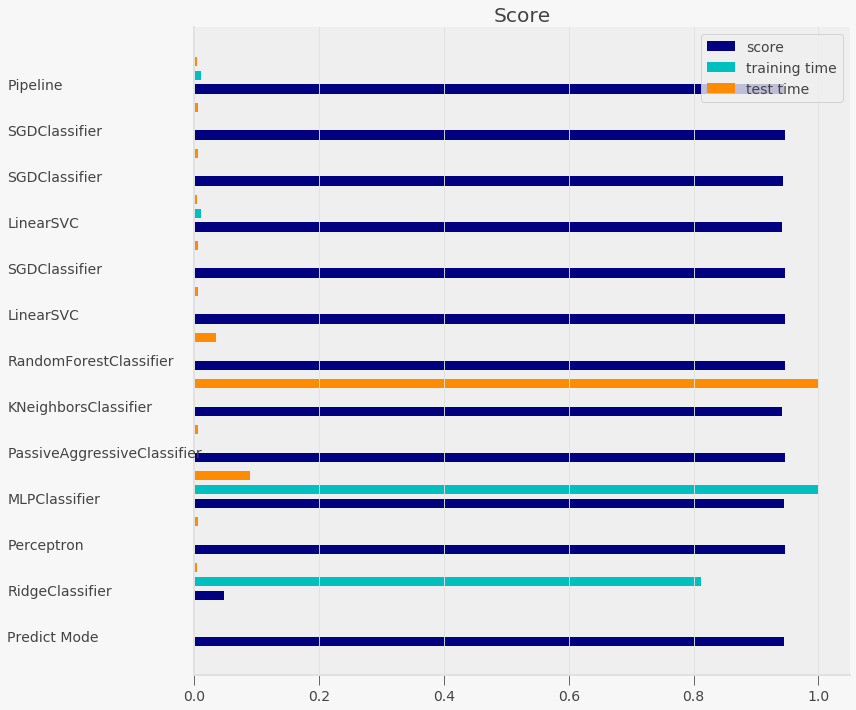

In [70]:
np.seterr('ignore')
description_results = rank_classifiers(sparse_X_train, sparse_X_test, y_train, y_test, 100)
plot_rankings(description_results)

Unfortunately, we were not able to produce significantly better performing predictions than simply always guessing that the loans will be fully funded. While it might be possible with better tuned models, using more of the dataset, better feature selection, and running models for more iterations, there was no evidence found for this throughout the course of development.

Ultimately, it just may not be possible to predict given the information available when the loans are first posted, and has more to do with which loans get presented to users by Kiva.

## Conclusions

Kiva has grown significantly over the past 15 years. Despite the majority of loans still focusing on poorer countries, there are many options for the average user living in the US to help domestically of they so choose. Relative to ordinary loans, the default rates here are extremely good, implying that the loans tend to be successful. As shown in the section on the expected costs of loaning, if one has any amount of disposable income, wishes to help others, and believes in the power of investing in small businesses, then these microloans can be a worthwhile charitable option to consider without needing to lose a great deal in personal value.